# LTO: He data

In [1]:
import galpynostatic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Cargamos los datos para el radio Li/Ti de $0.8$ para las $C_{rates}$ utilizadas

In [2]:
C_rates = [0.1, 0.5, 1, 2, 5]

In [3]:
dataframes = [pd.read_csv(f"data/he/{crate}C.csv", header=None) for crate in C_rates]

Ploteamos las curvas para verlas, con el potencial de equilibrio y el de corte correspondientes.

In [4]:
eq_pot = 1.57  # este valor es "artificial"
vcut = 0.15

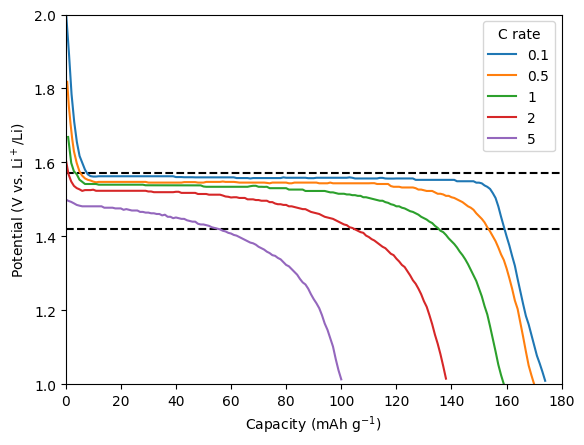

In [5]:
fig, ax = plt.subplots()

ax.axhline(y=eq_pot, color="k", linestyle="--")
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")
for crate, df in zip(C_rates, dataframes):
    ax.plot(df[0], df[1], label=f"{crate}")
    
ax.set_xlim((0, 180))
ax.set_ylim((1.0, 2.0))
ax.set_xlabel(r"Capacity (mAh g$^{-1}$)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

Podemos usar la herramienta desarrollada para obtener las capacidades de descarga

In [6]:
C_rates = np.asarray(C_rates).reshape(-1, 1)
xmaxs = galpynostatic.preprocessing.get_discharge_capacities(dataframes, eq_pot)
xmaxs

array([159.23154, 153.38335, 135.33395, 104.71328,  55.44732],
      dtype=float32)

Podemos normalizar estas corrientes por algún valor que deseemos

In [7]:
xmaxs = xmaxs / 160
xmaxs

array([0.9951971 , 0.95864594, 0.84583724, 0.654458  , 0.34654576],
      dtype=float32)

Y visualizar los datos que vamos a usar para ajustar

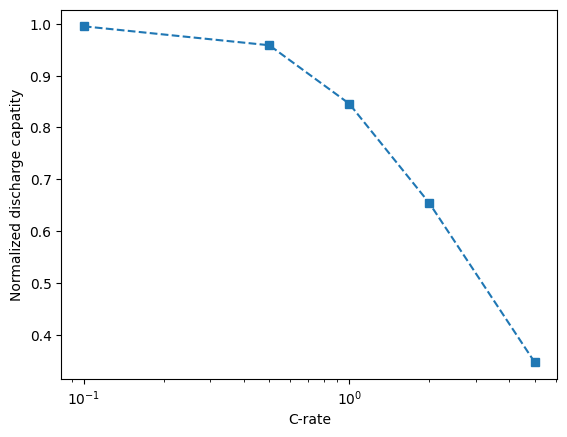

In [8]:
plt.plot(C_rates, xmaxs, marker="s", ls="--")

plt.xlabel("C-rate")
plt.ylabel("Normalized discharge capatity")
plt.xscale("log")
plt.show()

En el trabajo se menciona que los tamaños de particulas están distribuidos entre $0.5-3\mu m$, tomamos el punto medio como primera aproximación

In [9]:
d = 0.000175

Cargamos los datos de la superficie para la geometría esférica

In [10]:
dataset = galpynostatic.datasets.load_spherical()

Y fiteamos sobre la misma

In [11]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, 3)

greg.fit(C_rates, xmaxs)

Y el valor extrapolado para el coeficiente de difusión es de

In [12]:
greg.dcoeff_

6.579332246575682e-12

Mientras que el coeficiente de difusión reportado en este trabajo, para este ratio Li/Ti, es de $5.12\times10^{-12}$

mientras que el de k0 es

In [13]:
greg.k0_

8.111308307896873e-08

con un error cuadrático medio para el modelo de

In [14]:
greg.mse_

0.0006340848890754887

Podemos estimar el valor óptimo para la longuitud caracteristica de la nanoparticula, es decir el tamaño para obtener un 80% en 5 minutos

In [15]:
greg.t_minutes_lenght()

0.5284915510703524

Ploteamos los datos versus las predicciones

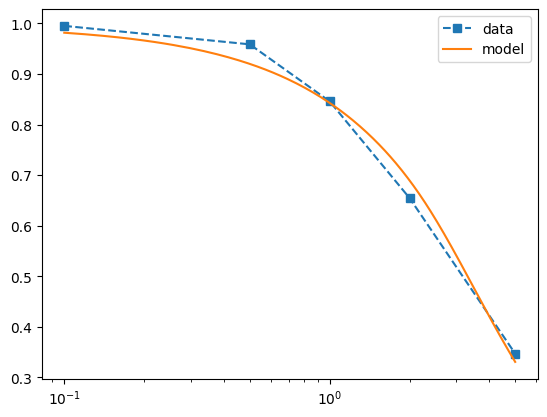

In [16]:
greg.plot_vs_data(C_rates, xmaxs)
plt.xscale("log")
plt.legend()
plt.show()

Por último, podemos observar la región del mapa en la que se encuentran estos resultados

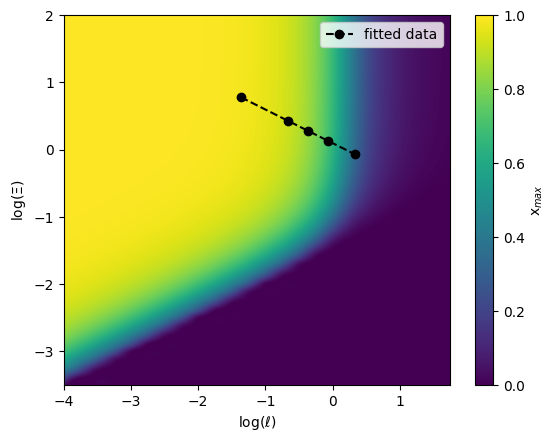

In [17]:
greg.plot_in_surface(C_rates)
plt.legend()
plt.show()